時系列データの特徴量の1つとして、ラグ変数というものがあります。例えば、日販（1日の売上）であれば、「ラグ1の変数」とは「1日前の日販の変数」、「ラグ2の変数」とは「2日前の日販の変数」などです。

今回は、説明変数のない目的変数が1変量の時系列データを扱いますので、目的変数のラグ変数を作り説明変数として利用します。
### このとき、ラグ変数を特徴量（features）として扱うこともできますし、タイムステップ（time steps）として扱うこともできます。

ということで、以下の2種類のデータセットそれぞれで、LSTMモデルを構築します。

In [1]:
# 必要なライブラリーの読み込み
#
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ

In [3]:
from google.cloud import bigquery
client = bigquery.Client('task-force-g00gle')

sql = """
    SELECT 
    CAST(date as datetime) AS Date,
    High,
    Low,
    Open,
    Close,
    Adj_Close
    FROM `finance_download.finance_edge`
    ORDER BY Date ASC
"""

stock_data = client.query(sql).to_dataframe()
print(stock_data.head(10))
print(stock_data.tail(10))

        Date  High  Low  Open  Close  Adj_Close
0 2022-02-17   794  640   694    668        668
1 2022-02-18   735  568   658    582        582
2 2022-02-21   606  482   535    482        482
3 2022-02-22   493  415   474    433        433
4 2022-02-24   490  412   439    446        446
5 2022-02-25   494  443   492    455        455
6 2022-02-28   464  435   451    453        453
7 2022-03-01   529  459   466    511        511
8 2022-03-02   565  502   516    530        530
9 2022-03-03   563  490   560    503        503
          Date  High  Low  Open  Close  Adj_Close
92  2022-07-05   860  832   849    848        848
93  2022-07-06   873  834   855    840        840
94  2022-07-07   843  809   843    817        817
95  2022-07-08   853  820   820    829        829
96  2022-07-11   879  840   850    847        847
97  2022-07-12   852  825   849    833        833
98  2022-07-13   844  816   833    825        825
99  2022-07-14   856  805   828    848        848
100 2022-07-15   855  

In [4]:
df = stock_data[['Date', 'Close']]
df.head()

,Date,Close
0,2022-02-17,668
1,2022-02-18,582
2,2022-02-21,482
3,2022-02-22,433
4,2022-02-24,446


In [5]:
df.shape

(102, 2)

<AxesSubplot:>

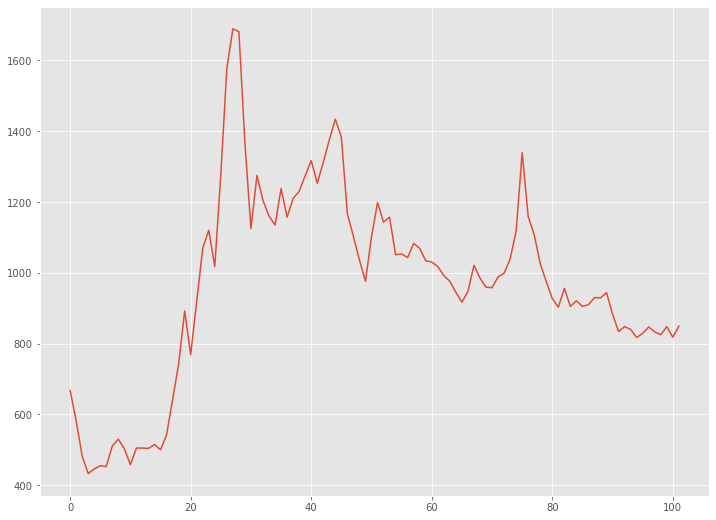

In [6]:
df.Close.plot()

In [7]:
## 変換
dataset = df.Close.values #NumPy配列へ変換
dataset = dataset.astype('float32')    #実数型へ変換
dataset = np.reshape(dataset, (-1, 1)) #1次元配列を2次元配列へ変換
print(dataset.shape)

(102, 1)


In [8]:
## ラグ付きデータセット生成関数
def gen_dataset(dataset, lag_max):
    X, y = [], []
    for i in range(len(dataset) - lag_max):
        a = i + lag_max
        X.append(dataset[i:a, 0]) #ラグ変数
        y.append(dataset[a, 0])   #目的変数
    return np.array(X), np.array(y)

In [9]:
## 分析用データセットの生成
lag_max = 5
X, y = gen_dataset(dataset, lag_max)
print(dataset[0:10])
print('='*100)
print(X)
print(X.shape)
print('='*100)
print(y)
print(y.shape)

[[668.]
 [582.]
 [482.]
 [433.]
 [446.]
 [455.]
 [453.]
 [511.]
 [530.]
 [503.]]
[[ 668.  582.  482.  433.  446.]
 [ 582.  482.  433.  446.  455.]
 [ 482.  433.  446.  455.  453.]
 [ 433.  446.  455.  453.  511.]
 [ 446.  455.  453.  511.  530.]
 [ 455.  453.  511.  530.  503.]
 [ 453.  511.  530.  503.  458.]
 [ 511.  530.  503.  458.  505.]
 [ 530.  503.  458.  505.  505.]
 [ 503.  458.  505.  505.  504.]
 [ 458.  505.  505.  504.  515.]
 [ 505.  505.  504.  515.  500.]
 [ 505.  504.  515.  500.  542.]
 [ 504.  515.  500.  542.  642.]
 [ 515.  500.  542.  642.  742.]
 [ 500.  542.  642.  742.  892.]
 [ 542.  642.  742.  892.  769.]
 [ 642.  742.  892.  769.  919.]
 [ 742.  892.  769.  919. 1069.]
 [ 892.  769.  919. 1069. 1120.]
 [ 769.  919. 1069. 1120. 1018.]
 [ 919. 1069. 1120. 1018. 1277.]
 [1069. 1120. 1018. 1277. 1577.]
 [1120. 1018. 1277. 1577. 1689.]
 [1018. 1277. 1577. 1689. 1681.]
 [1277. 1577. 1689. 1681. 1366.]
 [1577. 1689. 1681. 1366. 1125.]
 [1689. 1681. 1366. 1125. 12

In [10]:
# データ分割
#
test_length = 15 #テストデータの期間

X_train_0 = X[:-test_length,:] #学習データ
X_test_0 = X[-test_length:,:]  #テストデータ

y_train_0 = y[:-test_length] #学習データ
y_test_0 = y[-test_length:]  #テストデータ

y_train = y_train_0.reshape(-1,1)
y_test = y_test_0.reshape(-1,1)

In [11]:
print("shape X : " , X.shape)
print("shape y : " , y.shape)

shape X :  (97, 5)
shape y :  (97,)


In [12]:
# 正規化（0-1の範囲にスケーリング）
#
## 目的変数y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
y_test_norm = scaler_y.fit_transform(y_test)

## 説明変数X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_0 = scaler_X.fit_transform(X_train_0)
X_test_0 = scaler_X.transform(X_test_0)

In [13]:
X_train_0, X_test_0

(array([[0.1871019 , 0.11863059, 0.03901276, 0.        , 0.        ],
        [0.11863059, 0.03901276, 0.        , 0.01035032, 0.00724053],
        [0.03901276, 0.        , 0.01035032, 0.01751593, 0.00563154],
        [0.        , 0.01035032, 0.01751593, 0.01592359, 0.05229282],
        [0.01035032, 0.01751593, 0.01592359, 0.06210193, 0.06757843],
        [0.01751593, 0.01592359, 0.06210193, 0.07722932, 0.0458568 ],
        [0.01592359, 0.06210193, 0.07722932, 0.05573249, 0.00965405],
        [0.06210193, 0.07722932, 0.05573249, 0.01990446, 0.0474658 ],
        [0.07722932, 0.05573249, 0.01990446, 0.05732486, 0.0474658 ],
        [0.05573249, 0.01990446, 0.05732486, 0.05732486, 0.04666129],
        [0.01990446, 0.05732486, 0.05732486, 0.05652869, 0.05551085],
        [0.05732486, 0.05732486, 0.05652869, 0.06528664, 0.04344326],
        [0.05732486, 0.05652869, 0.06528664, 0.05334395, 0.07723251],
        [0.05652869, 0.06528664, 0.05334395, 0.08678344, 0.15768301],
        [0.06528664,

# LSTM（ラグ変数：features）

In [14]:
# モデル構築用にデータを再構成（サンプル数、タイムステップ, 特徴量数）
X_train = np.reshape(X_train_0, (X_train_0.shape[0], 1, X_train_0.shape[1]))
X_test = np.reshape(X_test_0, (X_test_0.shape[0], 1, X_test_0.shape[1]))

print('X_train:',X_train.shape) #確認
print('X_test:',X_test.shape) #確認
# print('X_train:',X_train) #確認
# print('X_test:',X_test) #確認

X_train: (82, 1, 5)
X_test: (15, 1, 5)


In [15]:
# モデル定義
model = Sequential()
model.add(LSTM(300, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# コンパイル
model.compile(loss='mean_squared_error', optimizer='adam')

# モデルの視覚化
# plot_model(model,show_shapes=True)
# model.summary()

2022-07-20 00:48:29.779833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-07-20 00:48:29.779881: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 00:48:29.779912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (4ed71eb0c8c1): /proc/driver/nvidia/version does not exist
2022-07-20 00:48:29.781907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

In [16]:
# EaelyStoppingの設定
early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)

# 学習の実行
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1, 
                    shuffle=False)

Epoch 1/1000
1/1 [==============================] - 4s 4s/step - loss: 0.2669 - val_loss: 0.1889
Epoch 2/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.2414 - val_loss: 0.1702
Epoch 3/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.2220 - val_loss: 0.1525
Epoch 4/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1992 - val_loss: 0.1359
Epoch 5/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1780 - val_loss: 0.1203
Epoch 6/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.1631 - val_loss: 0.1057
Epoch 7/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1449 - val_loss: 0.0921
Epoch 8/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1309 - val_loss: 0.0795
Epoch 9/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1134 - val_loss: 0.0680
Epoch 10/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1002 - val_loss: 0.0575
Epoch 11/10

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               367200    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 367,501
Trainable params: 367,501
Non-trainable params: 0
_________________________________________________________________


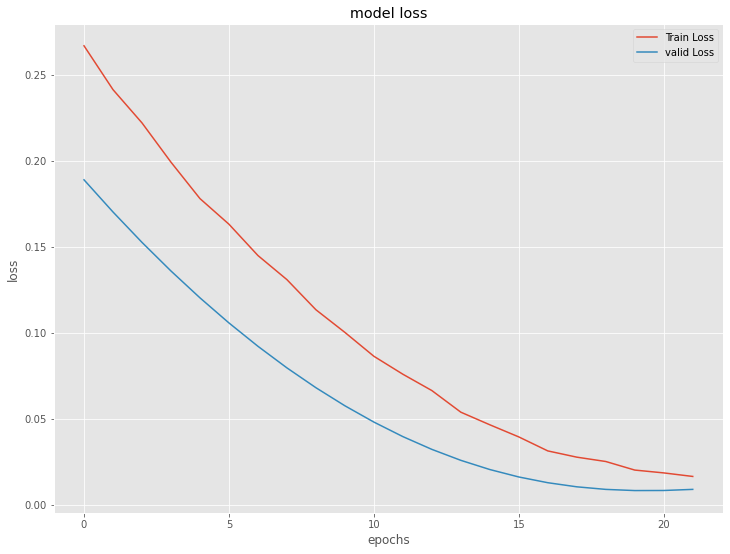

In [17]:
# 学習結果の出力
model.summary()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [18]:
# テストデータの目的変数を予測
y_test_pred = model.predict(X_test)

# スケールを戻す
y_test_pred = scaler_y.inverse_transform(y_test_pred)
# y_test = scaler_y.inverse_transform(y_test)
y_test_pred, y_test, len(y_test)

1/1 [==============================] - 0s 493ms/step


(array([[869.8158 ],
        [869.3394 ],
        [869.65784],
        [869.91644],
        [869.46204],
        [868.4219 ],
        [867.598  ],
        [866.34625],
        [864.08124],
        [863.2354 ],
        [863.55054],
        [863.1399 ],
        [862.81116],
        [863.46326],
        [863.2423 ]], dtype=float32),
 array([[930.],
        [929.],
        [944.],
        [883.],
        [834.],
        [848.],
        [840.],
        [817.],
        [829.],
        [847.],
        [833.],
        [825.],
        [848.],
        [818.],
        [849.]], dtype=float32),
 15)

RMSE:
40.101677
MAE:
35.6415
MAPE:
0.041104794


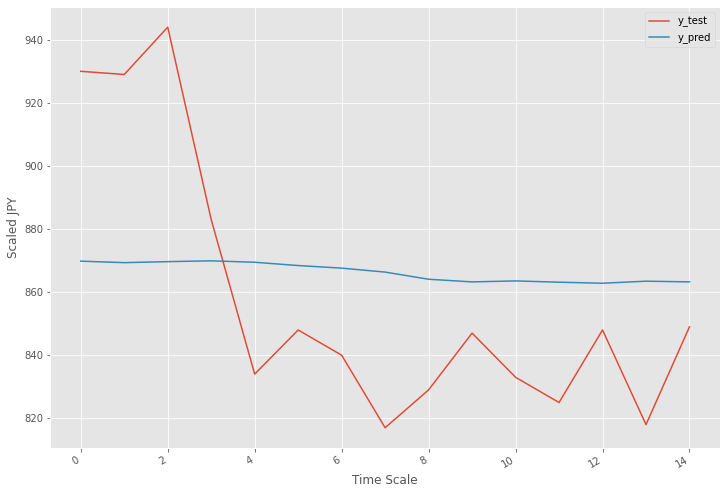

In [19]:
# 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MAE:')
print(mean_absolute_error(y_test, y_test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(y_test, y_test_pred)) 

plt.plot(y_test, label='y_test')
plt.plot(y_test_pred, label='y_pred')
plt.xlabel('Time Scale')
plt.ylabel('Scaled JPY')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

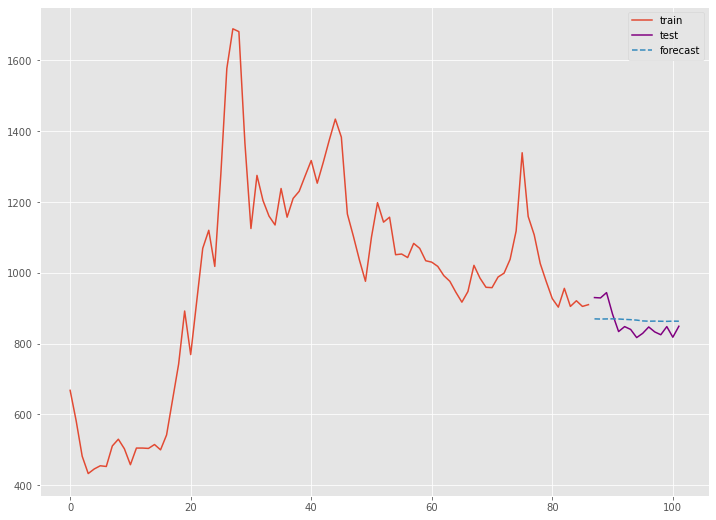

In [20]:
series = df["Close"] 
split_time = dataset.shape[0] - test_length # トレーニング期間とテスト期間の分割地点
train = series[:split_time]
test = series[split_time:]
plt.plot(np.arange(split_time), train, label="train")
plt.plot(np.arange(split_time, len(series)), test, label="test", color="purple")
plt.plot(np.arange(split_time, len(series)), y_test_pred, '--', label="forecast")
plt.legend()
plt.show()
#日付のインデックスで持ててないので、予測できない。
#arrayでデータを持っているのでできていない。
#来週5日を予測
#x軸を日付で表示

[[[0.32961786 0.31847137 0.3121019  0.330414   0.29927593]]] (1, 1, 5)
[[0.25196886]] (1, 1)
0
[[[0.31847137 0.3121019  0.330414   0.29927593]]] (1, 1, 4)
[[[0.31847137 0.3121019  0.330414   0.29927593 0.25196886]]] (1, 1, 5)
1/1 [==============================] - 0s 45ms/step
[[0.35160995]]
861
1日後の予測値は861
1
[[[0.3121019  0.330414   0.29927593 0.25196886]]] (1, 1, 4)
[[[0.3121019  0.330414   0.29927593 0.25196886 0.35160995]]] (1, 1, 5)
1/1 [==============================] - 0s 23ms/step
[[0.3608564]]
862
2日後の予測値は862
2
[[[0.330414   0.29927593 0.25196886 0.35160995]]] (1, 1, 4)
[[[0.330414   0.29927593 0.25196886 0.35160995 0.3608564 ]]] (1, 1, 5)
1/1 [==============================] - 0s 22ms/step
[[0.36707413]]
863
3日後の予測値は863
3
[[[0.29927593 0.25196886 0.35160995 0.3608564 ]]] (1, 1, 4)
[[[0.29927593 0.25196886 0.35160995 0.3608564  0.36707413]]] (1, 1, 5)
1/1 [==============================] - 0s 21ms/step
[[0.36711502]]
863
4日後の予測値は863
4
[[[0.25196886 0.35160995 0.3608564  0.3670

<function matplotlib.pyplot.show(close=None, block=None)>

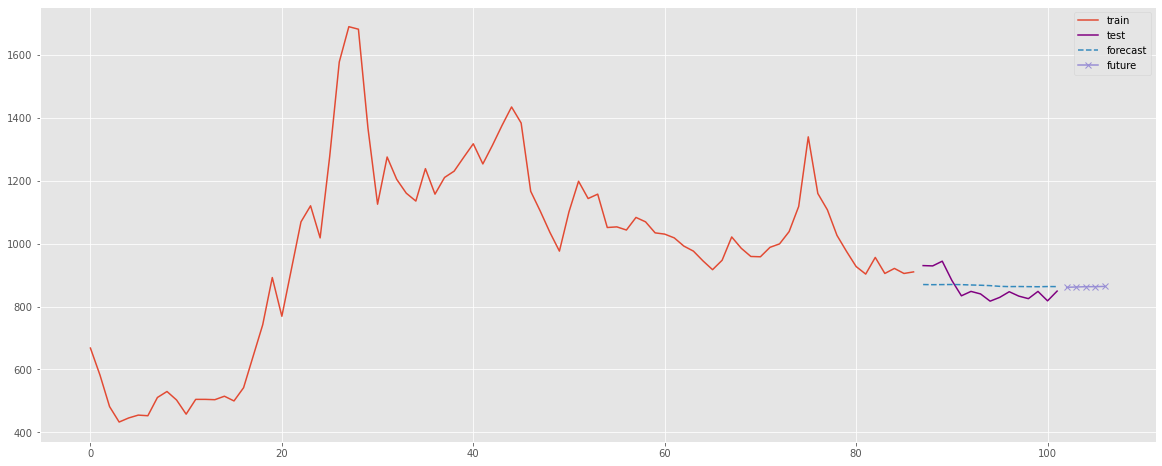

In [21]:
##### 将来予測を考える #####
# 予測ポイント数
target_num = 5

# 予測値を格納するリスト
pred_list = []

# ラスト1行の X(norm) の値を取得する
target_x = X_test[-1:]
print(target_x, target_x.shape)

# ラスト1行の y の値を取得する
target_y = y_test_norm[-1:]
print(target_y, target_y.shape)
print("="*100)
print("="*100)

# 予測血を用いて予測を実施する
for i in range(target_num):
    print(i)
    
    # x1を削除
    target_x_d = np.delete(target_x, 0, axis=2)
    print(target_x_d, target_x_d.shape)

    # x5を追加
    target_x_a = np.append(target_x_d, [target_y], axis=2)
    print(target_x_a, target_x_a.shape)

    # 訓練済み学習器によって次の日を予測
    y_test_future_pred_norm = model.predict(target_x_a)
    print(y_test_future_pred_norm)
    
    # スケールを戻して整数にして予測値とする
    y_test_future_pred = np.int(scaler_y.inverse_transform(y_test_future_pred_norm))
    print(y_test_future_pred)

    # 最後の Y に予測値を追加
    target_y = y_test_future_pred_norm
    
    print(str(i+1) + "日後の予測値は" + str(y_test_future_pred))
    
    i+=1
    
    target_x = target_x_a
    pred_list.append(y_test_future_pred)
    
    print("="*100)

print(str(target_num) + "日分の予測値結果：" + ",".join([str(_) for _ in pred_list]))
print("="*100)
print("="*100)

# 予測結果の可視化
plt.rcParams['figure.figsize'] = [20, 8] # グラフサイズ

series = df["Close"] 
split_time = dataset.shape[0] - test_length # トレーニング期間とテスト期間の分割地点
train = series[:split_time]
test = series[split_time:]
plt.plot(np.arange(split_time), train, label="train")
plt.plot(np.arange(split_time, len(series)), test, label="test", color="purple")
plt.plot(np.arange(split_time, len(series)), y_test_pred, '--', label="forecast")
plt.plot(np.arange(len(series), len(series) + target_num), pred_list, marker = 'x', label="future")
plt.legend()
plt.show

# LSTM（ラグ変数：time steps）

In [22]:
# モデル構築用にデータを再構成（サンプル数、タイムステップ, 特徴量数）
X_train = np.reshape(X_train_0, (X_train_0.shape[0], X_train_0.shape[1], 1))
X_test = np.reshape(X_test_0, (X_test_0.shape[0], X_test_0.shape[1], 1))

print('X_train:',X_train.shape) #確認
print('X_test:',X_test.shape) #確認

X_train: (82, 5, 1)
X_test: (15, 5, 1)


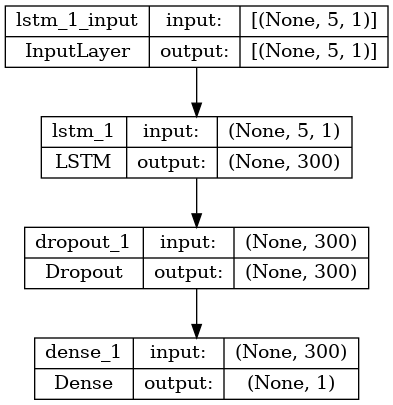

In [23]:
# モデル定義
model = Sequential()
model.add(LSTM(300,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# コンパイル
model.compile(loss='mean_squared_error', optimizer='adam')

# モデルの視覚化
plot_model(model,show_shapes=True)

In [24]:
# EaelyStoppingの設定
early_stopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0.0,
                                patience=2)
# 学習の実行
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stopping] ,
                    verbose=1, 
                    shuffle=False)

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 0.2656 - val_loss: 0.1530
Epoch 2/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.2039 - val_loss: 0.1056
Epoch 3/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.1434 - val_loss: 0.0669
Epoch 4/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.1012 - val_loss: 0.0370
Epoch 5/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0599 - val_loss: 0.0172
Epoch 6/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0349 - val_loss: 0.0096
Epoch 7/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0198 - val_loss: 0.0159
Epoch 8/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0208 - val_loss: 0.0320


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 300)               362400    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


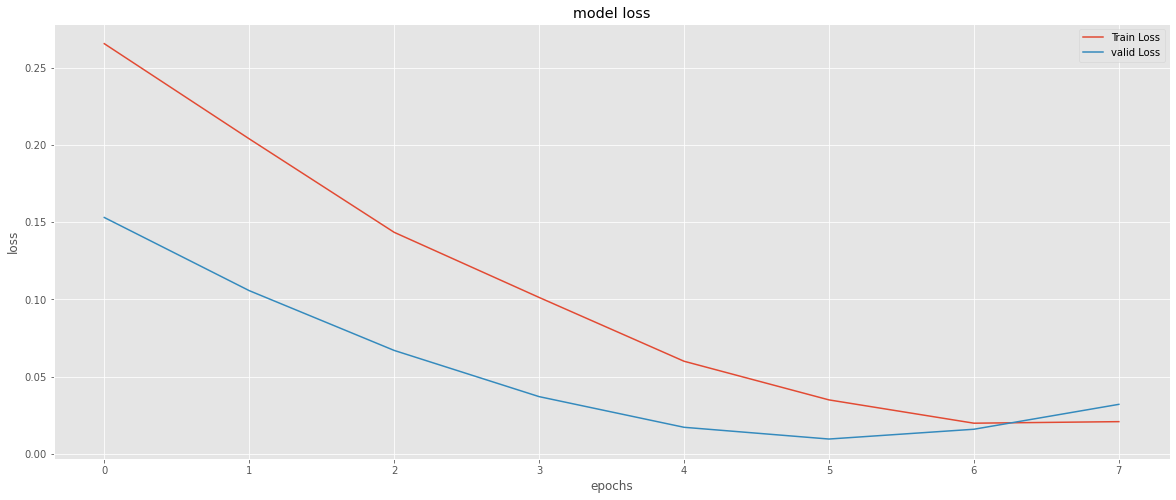

In [25]:
# 学習結果の出力
model.summary()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='valid Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [26]:
y_test_pred = model.predict(X_test)

# スケールを戻す
y_test_pred = scaler_y.inverse_transform(y_test_pred)

1/1 [==============================] - 0s 454ms/step


RMSE:
43.92781
MAE:
41.051662
MAPE:
0.047958832


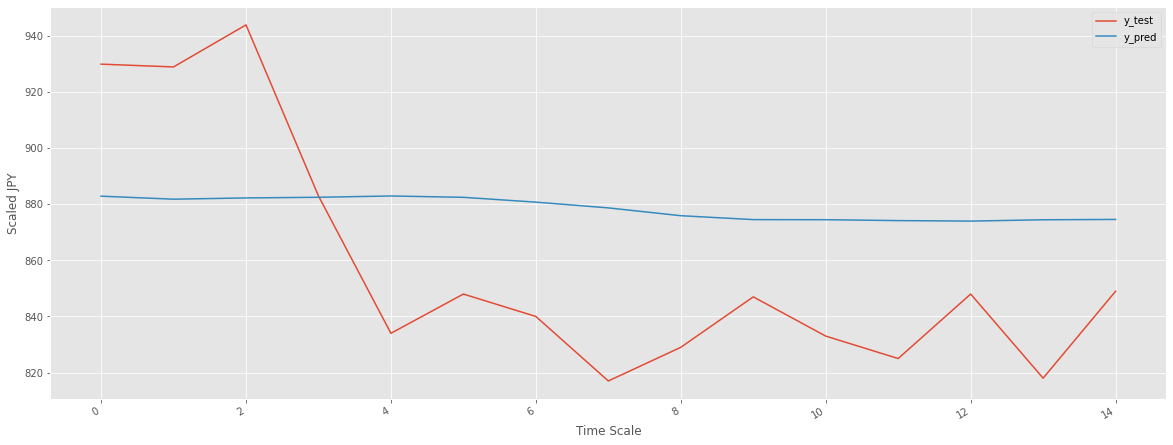

In [27]:
print('RMSE:')
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('MAE:')
print(mean_absolute_error(y_test, y_test_pred)) 
print('MAPE:')
print(mean_absolute_percentage_error(y_test, y_test_pred)) 

plt.plot(y_test, label='y_test')
plt.plot(y_test_pred, label='y_pred')
plt.xlabel('Time Scale')
plt.ylabel('Scaled JPY')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()